# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://platform.wbscodingschool.com/courses/data-science/9474/) and use what you've learnt to see how reliable the data is.

In [1]:
import pandas as pd

Load our cleaned DataFrames

In [4]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [3]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

## 2.&nbsp; Exclude unwanted orders

In [5]:
orders_cl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226904 entries, 0 to 226903
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226904 non-null  int64  
 1   created_date  226904 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226904 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [7]:
#orders can be 'Cancelled', 'Completed', 'Pending', 'Shopping Basket', 'Place Order'
#We just keep 'Completed'
orders_cl = orders_cl.loc[orders_cl["state"]=="Completed",:].copy()
orders_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      46605 non-null  int64  
 1   created_date  46605 non-null  object 
 2   total_paid    46605 non-null  float64
 3   state         46605 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ MB


In [5]:
#To make sure we have matching orders and orderlines we perform an inner join
orders_new = orders_cl.merge(
    orderlines_cl,
    how = "inner",
    left_on = "order_id",
    right_on = "id_order"
)

In [6]:
#We first clear both dataframes

orderlines_cl.drop(orderlines_cl.index, inplace=True)
orders_cl.drop(orders_cl.index, inplace=True)

#And then update them: 
#Orderlines –> Keep only orders present in orders
orderlines_cl["id"] = orders_new["id"]
orderlines_cl["id_order"] = orders_new["id_order"]
orderlines_cl["product_id"] = orders_new["product_id"]
orderlines_cl["product_quantity"] = orders_new["product_quantity"]
orderlines_cl["sku"] = orders_new["sku"]
orderlines_cl["unit_price"] = orders_new["unit_price"]
orderlines_cl["date"] = orders_new["date"]

#Orders –> Keep only orders present in orderlines.
orders_cl["order_id"] = orders_new["order_id"]
orders_cl["created_date"] = orders_new["created_date"]
orders_cl["total_paid"] = orders_new["total_paid"]
orders_cl["state"] = orders_new["state"]

## 3.&nbsp; Exclude orders with unknown products


In [7]:
#Let's check if orders_new["sku"] is in the products table
orders_new["sku"].isin(products_cl["sku"]).value_counts(normalize=True)
#Only the 2% of orders_new["sku"] is not in products

True    0.98
False   0.02
Name: sku, dtype: float64

In [8]:
#We first identify the patological indexes
pat_index = orders_new.loc[orders_new["sku"].isin(products_cl["sku"])== False,:].index

#We then drop them
orders_new.drop(index= pat_index, axis=1, inplace = True)

#Let's double checl
orders_new["sku"].isin(products_cl["sku"]).value_counts(normalize=True)
#🎉🎉


True   1.00
Name: sku, dtype: float64

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [9]:
orderlines_cl['unit_price_total']= orderlines_cl['unit_price'] * orderlines_cl['product_quantity']
orderlines_cl[["id_order","product_quantity","unit_price","unit_price_total"]].head(2)

,id_order,product_quantity,unit_price,unit_price_total
0,241423,1,129.16,129.16
1,242832,1,10.77,10.77


#### Step 2: 
Group by `order_id`, summarising by the sum of `unit_price_total`

In [10]:
grouped_orderlines= orderlines_cl.groupby("id_order").agg({"unit_price_total":"sum"})

orders_merged= orders_cl.merge(
    grouped_orderlines,
    how = "left",
    left_on = "order_id",
    right_on = "id_order"
)

orders_merged

,order_id,created_date,total_paid,state,unit_price_total
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98
...,...,...,...,...,...
56709,527042,2018-03-14 11:47:50,18.98,Completed,13.99
56710,527070,2018-03-14 11:50:48,24.97,Completed,19.98
56711,527074,2018-03-14 11:51:42,24.97,Completed,19.98
56712,527096,2018-03-14 11:58:40,34.96,Completed,29.97


### What is the average difference between `total_paid` and `unit_price_total`?

In [11]:
#Let us introduce a new column for the difference
orders_merged["diff"] = orders_merged['total_paid']-orders_merged['unit_price_total']
orders_merged.groupby("state").agg({"diff":"mean"})

,diff
state,
Completed,4.34


### What is the distribution of these differences?

In [12]:
orders_merged[["diff"]].describe()

,diff
count,56714.00
mean,4.34
std,22.55
min,-165.00
25%,0.00
50%,4.99
75%,6.99
max,3984.99


array([[<Axes: title={'center': 'diff'}>]], dtype=object)

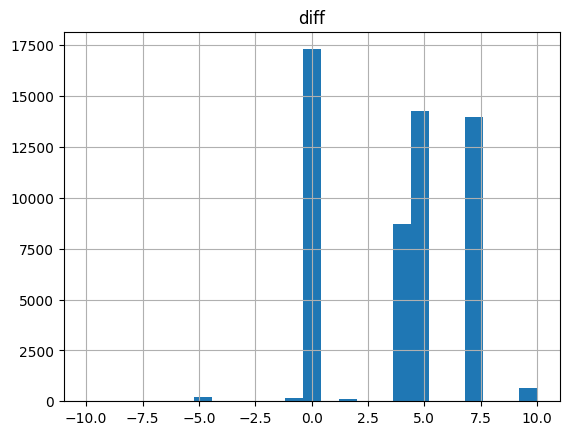

In [13]:
#We reduce the range of the x-axis
orders_merged.hist(column="diff",range=[-10,10],bins=25)

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

In [14]:
#Not all the differences can be explained by shipping costs as there are some negative values
#I guess plausible explanation might involve discounts

Perform a similar process comparing orderlines.unit_price with products.price. Differences here should be explained by discounts, which is precisely the main objective of this project!

In [15]:
#A product can appear in different order lines
#To compare the actual price it has been sold to and the original price we merge the two table as follows
olines_products = orderlines_cl.merge(
    products_cl,
    how = "left",
    left_on = "sku",
    right_on = "sku"
)

#Now we add a column for the difference
olines_products["diff"] = olines_products["price"]-olines_products["unit_price"]
olines_products["diff"].describe()

count   55320.00
mean       26.71
std        47.07
min      -170.99
25%         5.46
50%        15.00
75%        31.60
max      1320.00
Name: diff, dtype: float64

### If there are differences that you can’t explain: what should you do with these orders?

In [16]:
#Maybe drop them?

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

In [17]:
# your thoughts & code here

Do not forget to download your quality controlled DataFrames

In [18]:
from google.colab import files

#orders_quality_controlled.to_csv("orders_qu.csv", index=False)
#files.download("orders_qu.csv")

#orderlines_quality_controlled.to_csv("orderlines_qu.csv", index=False)
#files.download("orderlines_qu.csv")